# 😴 24-Hour Sleep Timeline 💤
<p align="center">
  <img src="imgs/data_dreaming.png" alt="24-Hour Sleep Timeline EDA" width="400"/>
</p>

## 📋 Quick Start Guide

This notebook has been updated to work with **local parquet data** instead of fetching from S3.

### How to Use:

1. **Set your date range** in the configuration section:
   - `START_DATE`: Beginning of date range (e.g., `'2025-11-01'`)
   - `END_DATE`: End of date range (e.g., `'2025-11-10'`)
   - Set to `None` to load all available data

2. **Choose analysis mode**:
   - **Multi-day analysis**: Analyzes all dates in the range (trends, aggregates)
   - **Single-day analysis**: Set `ANALYSIS_DATE` to analyze a specific date in detail

3. **Run all cells** to load data and generate visualizations

4. **Data source**: `../data/fitbit_compiled.parquet`

### Features:
- ✅ Works with local parquet file (no S3 required)
- ✅ Date range filtering to load only what you need
- ✅ Multi-day trend analysis (NEW!)
- ✅ Single-day detailed analysis
- ✅ Automatic timezone handling

---

## 📦 Imports

In [162]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns

## 📥 Data Import Functions

### Load Data from Local Parquet File

In [163]:
def load_fitbit_data_from_parquet(parquet_path='../data/fitbit_compiled.parquet', start_date=None, end_date=None):
    """
    Load Fitbit data from local parquet file with optional date range filtering.
    
    Args:
        parquet_path: Path to the parquet file (default: '../data/fitbit_compiled.parquet')
        start_date: Optional start date as string 'YYYY-MM-DD' or datetime
        end_date: Optional end date as string 'YYYY-MM-DD' or datetime
    
    Returns:
        pd.DataFrame: Complete DataFrame with all measurements
    
    Examples:
        # Load all data
        df = load_fitbit_data_from_parquet()
        
        # Load specific date
        df = load_fitbit_data_from_parquet(start_date='2025-11-01', end_date='2025-11-01')
        
        # Load date range
        df = load_fitbit_data_from_parquet(start_date='2025-11-01', end_date='2025-11-10')
    """
    print(f"📥 Loading data from {parquet_path}...")
    
    # Load parquet file
    df = pd.read_parquet(parquet_path)
    
    # Clean column names - remove field_ and tag_ prefixes
    rename_dict = {}
    for col in df.columns:
        if col.startswith('field_'):
            rename_dict[col] = col.replace('field_', '')
        elif col.startswith('tag_'):
            rename_dict[col] = col.replace('tag_', '')
    
    if rename_dict:
        df = df.rename(columns=rename_dict)
        print(f"✅ Cleaned {len(rename_dict)} column names")
    
    # Ensure time column is datetime with timezone
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    # Add timezone if not present (assume UTC from source data)
    if df['time'].dt.tz is None:
        df['time'] = df['time'].dt.tz_localize('UTC')
    
    print(f"✅ Loaded {len(df)} total records")
    
    # Apply date filtering if specified
    if start_date or end_date:
        # Convert string dates to datetime if needed
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date).tz_localize('UTC')
        if isinstance(end_date, str):
            # Add one day to include the entire end date
            end_date = (pd.to_datetime(end_date) + pd.Timedelta(days=1)).tz_localize('UTC')
        
        # Filter by date range
        if start_date:
            df = df[df['time'] >= start_date]
        if end_date:
            df = df[df['time'] < end_date]
        
        print(f"📅 Filtered to date range: {len(df)} records")
        if start_date:
            print(f"   From: {start_date.strftime('%Y-%m-%d')}")
        if end_date:
            print(f"   To: {(end_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
    
    return df

In [164]:
def get_sleep_data_for_date(df, date_str):
    """
    Extract sleep data for a specific SLEEP DATE from the loaded DataFrame.
    
    This function finds the main sleep session that belongs to the specified date
    (using the same sleep date logic as the visualizations) and returns all data
    for that session only.
    
    Args:
        df: DataFrame loaded from parquet
        date_str: Sleep date in format 'YYYY-MM-DD'
    
    Returns:
        dict: Dictionary containing 'SleepLevels' and 'SleepSummary' DataFrames for that sleep session
    """
    try:
        target_date = datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        raise ValueError("Date must be in format 'YYYY-MM-DD'")
    
    print(f"\n📥 Extracting sleep data for sleep date {target_date.strftime('%Y-%m-%d')}...")
    
    # Get all sleep summaries and convert timezone
    df_summary = df[df['measurement'] == 'SleepSummary'].copy()
    
    if df_summary.empty:
        print(f"❌ No sleep summary data found")
        return None
    
    # Ensure end_time is calculated
    if 'endTime' in df_summary.columns:
        df_summary['end_time'] = pd.to_datetime(df_summary['endTime'])
    elif 'end_time' not in df_summary.columns:
        df_summary['end_time'] = df_summary['time'] + pd.to_timedelta(df_summary['minutesInBed'], unit='m')
    
    # Convert to local timezone for sleep date calculation
    if df_summary['time'].dt.tz is None:
        df_summary['time'] = df_summary['time'].dt.tz_localize('UTC')
    if df_summary['end_time'].dt.tz is None:
        df_summary['end_time'] = df_summary['end_time'].dt.tz_localize('UTC')
        
    df_summary['time'] = df_summary['time'].dt.tz_convert('Europe/London')
    df_summary['end_time'] = df_summary['end_time'].dt.tz_convert('Europe/London')
    
    # Calculate sleep date for each session
    def get_sleep_date(row):
        sleep_hour = row['time'].hour
        if sleep_hour >= 18:
            return row['time'].date()
        elif sleep_hour < 6:
            return (row['time'] - pd.Timedelta(days=1)).date()
        else:
            return row['time'].date()
    
    df_summary['sleep_date'] = df_summary.apply(get_sleep_date, axis=1)
    
    # Filter for the target sleep date
    matching_sessions = df_summary[df_summary['sleep_date'] == target_date]
    
    if matching_sessions.empty:
        print(f"❌ No sleep session found for sleep date {target_date.strftime('%Y-%m-%d')}")
        print(f"   Available sleep dates: {sorted(df_summary['sleep_date'].unique())}")
        return None
    
    # Get the main sleep session for this date
    main_sleep = matching_sessions[matching_sessions.get('isMainSleep', 'True') == 'True']
    
    if main_sleep.empty:
        # If no main sleep, use the first session
        session = matching_sessions.iloc[0]
    else:
        session = main_sleep.iloc[0]
    
    session_start = session['time'].tz_convert('UTC')
    session_end = session['end_time'].tz_convert('UTC')
    
    print(f"✅ Found sleep session for {target_date.strftime('%Y-%m-%d')}")
    print(f"   Sleep time: {session['time'].strftime('%Y-%m-%d %H:%M')} to {session['end_time'].strftime('%Y-%m-%d %H:%M')}")
    
    # Get sleep levels for this specific session
    df_levels = df[df['measurement'] == 'SleepLevels'].copy()
    
    if df_levels.empty:
        print("   ⚠️  No sleep levels data found")
        return {
            'SleepSummary': matching_sessions,
            'SleepLevels': pd.DataFrame()
        }
    
    # Calculate end times for levels
    df_levels['end_time'] = df_levels['time'] + pd.to_timedelta(df_levels['duration_seconds'], unit='s')
    
    # Filter levels to this session's timeframe
    session_levels = df_levels[
        (df_levels['time'] >= session_start) & 
        (df_levels['time'] < session_end)
    ].copy()
    
    print(f"   Sleep levels: {len(session_levels)} records")
    print(f"   Sleep summary: {len(matching_sessions)} session(s)")
    
    return {
        'SleepLevels': session_levels,
        'SleepSummary': matching_sessions
    }

## 🎨 Sleep Analysis Constants & Configuration

In [165]:
# Color scheme for sleep stages
SLEEP_COLORS = {
    'Deep': '#0f172a',      # Midnight Navy — deep and restful
    'Light': '#a5d8ff',     # Pastel Blue — gentle and calming
    'REM': '#c084fc',       # Soft Lavender — dreamy and ethereal
    'Awake': '#fde047'      # Butter Yellow — bright but soft
}

# SLEEP_COLORS = {
#    'Awake': '#ff6b6b',
#    'REM': '#9b59b6',
#    'Light': '#3498db',
#    'Deep': '#2c3e50'
# }

TIMEZONE = 'Europe/London'

# Map numeric levels to names
level_decode = {
    0: 'Deep',
    1: 'Light',
    2: 'REM',
    3: 'Awake'
}

## 🔧 Helper Functions

In [166]:
def _get_main_sleep_session(df_summary):
    """Extract the main sleep session from summary dataframe."""
    if df_summary.empty:
        return None
    
    summary = df_summary.copy()
    if 'isMainSleep' in summary.columns:
        main_sleep = summary[summary['isMainSleep'] == 'True']
        if not main_sleep.empty:
            summary = main_sleep
    
    return summary.iloc[0]

In [167]:
def _prepare_sleep_data(df_levels, df_summary, start_time, end_time):
    """
    Prepare sleep level data for a 24-hour window.
    Adds Awake periods at the start, between sessions, and at the end.
    """
    # Convert all level times to local timezone
    levels = df_levels.copy()
    levels['time'] = levels['time'].dt.tz_convert(TIMEZONE)
    levels['end_time'] = levels['end_time'].dt.tz_convert(TIMEZONE)
    
    # Filter levels for this time window
    levels = levels[
        (levels['time'] >= start_time) & 
        (levels['time'] < end_time)
    ].copy()
    
    if levels.empty:
        return levels
    
    # Sort by time
    levels = levels.sort_values('time').reset_index(drop=True)
    
    # Get all sleep sessions from summary (converted to local timezone)
    summary = df_summary.copy()
    summary['time'] = summary['time'].dt.tz_convert(TIMEZONE)
    summary['end_time'] = summary['end_time'].dt.tz_convert(TIMEZONE)
    
    # Sort sessions by start time
    summary = summary.sort_values('time').reset_index(drop=True)
    
    gaps_to_add = []
    
    # Add Awake period from midnight to first sleep session
    if not summary.empty:
        first_session_start = summary['time'].min()
        
        if start_time < first_session_start:
            gap_seconds = (first_session_start - start_time).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake before first session: {gap_seconds/60:.1f} min ({start_time.strftime('%H:%M')} to {first_session_start.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': start_time,
                    'end_time': first_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # For each sleep session, check if stages data ends before session end_time
    for idx, session in summary.iterrows():
        session_start = session['time']
        session_end = session['end_time']
        session_type = "NAP" if session.get('isMainSleep') == 'False' else "MAIN SLEEP"
        
        # Get stages for this session
        session_stages = levels[
            (levels['time'] >= session_start) & 
            (levels['time'] < session_end)
        ]
        
        if not session_stages.empty:
            last_stage_end = session_stages['end_time'].max()
            
            # If stages end before session end, add Awake period
            if last_stage_end < session_end:
                gap_seconds = (session_end - last_stage_end).total_seconds()
                
                if gap_seconds > 30:  # More than 30 seconds
                    # print(f"   ⚠️  Adding Awake at end of {session_type}: {gap_seconds/60:.1f} min ({last_stage_end.strftime('%H:%M')} to {session_end.strftime('%H:%M')})")
                    
                    gaps_to_add.append({
                        'time': last_stage_end,
                        'end_time': session_end,
                        'level': 3.0,
                        'level_name': 'Awake',
                        'duration_seconds': gap_seconds,
                        'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                    })
    
    # Find gaps BETWEEN sessions (awake time between nap and main sleep, etc.)
    for i in range(len(summary) - 1):
        current_session_end = summary.iloc[i]['end_time']
        next_session_start = summary.iloc[i + 1]['time']
        
        if current_session_end < next_session_start:
            gap_seconds = (next_session_start - current_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake between sessions: {gap_seconds/60:.1f} min ({current_session_end.strftime('%H:%M')} to {next_session_start.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': current_session_end,
                    'end_time': next_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add Awake period from last session end to midnight (end_time)
    if not summary.empty:
        last_session_end = summary['end_time'].max()
        
        if last_session_end < end_time:
            gap_seconds = (end_time - last_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake after last session to midnight: {gap_seconds/60:.1f} min ({last_session_end.strftime('%H:%M')} to {end_time.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': last_session_end,
                    'end_time': end_time,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add all gaps
    if gaps_to_add:
        levels = pd.concat([levels, pd.DataFrame(gaps_to_add)], ignore_index=True)
        levels = levels.sort_values('time').reset_index(drop=True)
    
    return levels

In [168]:
def _plot_sleep_bars(ax, levels):
    seen_labels = set()

    for idx, row in levels.iterrows():
        stage = row['level_name']
        color = SLEEP_COLORS.get(stage, '#cccccc')
        duration_hours = row['duration_seconds'] / 3600
        
        label = stage if stage not in seen_labels else None
        seen_labels.add(stage)

        ax.barh(
            y=0,
            width=duration_hours,
            left=row['time'],
            height=0.8,
            color=color,
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9,
            label=label
        )

In [169]:
def _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15):
    """Apply common formatting to timeline axis."""
    from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter, AutoDateLocator
    
    # Create a formatter that's timezone-aware
    formatter = DateFormatter('%H:%M', tz=start_time.tz)
    ax.xaxis.set_major_formatter(formatter)
    
    # Calculate time span to verify
    time_span_hours = (end_time - start_time).total_seconds() / 3600
    
    # For a 24-hour period, use HourLocator or AutoDateLocator
    if time_span_hours > 6:
        # Use hourly ticks for longer periods within the day
        ax.xaxis.set_major_locator(HourLocator(interval=1, tz=start_time.tz))
    elif time_span_hours > 2:
        # Use 15-30 minute intervals for medium periods
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30), tz=start_time.tz))
    else:
        # Only use fine-grained intervals for very short periods
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, interval_minutes), tz=start_time.tz))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.set_xlim(start_time, end_time)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [170]:
def _add_sleep_legend(ax, location='upper right'):
    """Add standard sleep stage legend to axis."""
    legend_elements = [
        mpatches.Patch(facecolor=SLEEP_COLORS['Deep'], label='Deep', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Light'], label='Light', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['REM'], label='REM', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Awake'], label='Awake', edgecolor='white')
    ]
    ax.legend(handles=legend_elements, loc=location, ncol=4, fontsize=11, framealpha=0.9)

## 📊 Main Plotting Functions

In [171]:
def plot_sleep_timeline(df_levels, df_summary):
    """Plot a horizontal timeline showing sleep stages throughout a 24-hour period."""

    if df_levels.empty or df_summary.empty:
        print(f"❌ No sleep data found")
        return None

    # Get the main sleep session to determine the date and window
    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True']
    if main_sleep.empty:
        main_sleep = df_summary.iloc[[0]]  # Fallback to first session

    main_sleep_start = main_sleep.iloc[0]['time']
    main_sleep_end = main_sleep.iloc[0]['end_time']
    sleep_hour = main_sleep_start.hour
    
    # Actual date (for window calculations)
    actual_date = main_sleep_start.date()

    # Determine the "sleep night date" - the date we should LABEL this sleep as
    if sleep_hour >= 18:
        sleep_date = actual_date
    elif sleep_hour < 6:
        sleep_date = (main_sleep_start - pd.Timedelta(days=1)).date()
    else:
        sleep_date = actual_date

    # Smart window selection based on main sleep start time
    if sleep_hour < 18:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "midnight-to-midnight"
    else:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE) + pd.Timedelta(hours=12)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "noon-to-noon"

    # Console summary
    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        print(f"   📅 Sleep Date: {sleep_date.strftime('%A %dth %B %Y')}")
        print(f"   📊 Window: {day1.strftime('%A %dth %B')} noon → {day2.strftime('%A %dth %B')} noon")
    else:
        print(f"   📅 Sleep Date: {sleep_date.strftime('%A %dth %B %Y')}")

    print(f"   🌙 To Bed: {main_sleep_start.strftime('%H:%M on %A %dth %B')}")
    print(f"   ☀️ Woke Up: {main_sleep_end.strftime('%H:%M on %A %dth %B')}\n")

    # FIXED: Use session times with _prepare_sleep_data to avoid huge Awake gaps
    # Pass the session boundaries to ensure we only add small gaps within the session
    levels = _prepare_sleep_data(df_levels, df_summary, main_sleep_start, main_sleep_end)
    if levels.empty:
        print(f"❌ No sleep level data found for this period")
        return None

    fig, ax = plt.subplots(figsize=(16, 4))
    _plot_sleep_bars(ax, levels)

    # Add "To Bed" and "Up" markers on the timeline
    ax.axvline(main_sleep_start, linestyle="--", linewidth=1.2)
    ax.text(
        main_sleep_start,
        1.05,
        "To Bed",
        ha="center",
        va="bottom",
        fontsize=10,
        transform=ax.get_xaxis_transform()
    )

    ax.axvline(main_sleep_end, linestyle="--", linewidth=1.2)
    ax.text(
        main_sleep_end,
        1.05,
        "Up",
        ha="center",
        va="bottom",
        fontsize=10,
        transform=ax.get_xaxis_transform()
    )

    # Generate title based on sleep date
    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        title = (
            f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'
            f'({day1.strftime("%a %d %b")} noon → {day2.strftime("%a %d %b")} noon window)\n'
        )
    else:
        title = f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'

    # Use session times for x-axis limits to avoid showing empty space
    _format_timeline_axis(ax, main_sleep_start, main_sleep_end, title, interval_minutes=60)

    legend_loc = "upper left" if window_type == "noon-to-noon" else "upper right"
    _add_sleep_legend(ax)
    ax.legend(loc=legend_loc)

    plt.tight_layout()
    plt.show()

    return fig

In [172]:
def plot_sleep_stages_pie(df_levels, df_summary):
    """Plot a pie chart showing the distribution of sleep stages in minutes."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    # Use SESSION times, not window times, for accurate stage distribution
    start_time = summary['time']
    end_time = summary['end_time']
    
    # Calculate the sleep date using same logic as plot_sleep_timeline
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    # DON'T use _prepare_sleep_data - it adds artificial Awake periods
    # Just filter levels to the session timeframe directly
    levels = df_levels.copy()
    levels = levels[
        (levels['time'] >= start_time) & 
        (levels['time'] < end_time)
    ].copy()
    
    if levels.empty:
        print(f"❌ No sleep level data found")
        return None
    
    # Calculate minutes per stage
    stage_minutes = levels.groupby('level_name')['duration_seconds'].sum() / 60
    non_awake = stage_minutes.sum() - stage_minutes.get('Awake', 0)
    hours_asleep = round(non_awake / 60, 2)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors_ordered = [SLEEP_COLORS[stage] for stage in stage_minutes.index]
    
    wedges, texts, autotexts = ax.pie(
        stage_minutes,
        labels=[f'{stage}\n{mins:.0f} min' for stage, mins in stage_minutes.items()],
        autopct='%1.1f%%',
        colors=colors_ordered,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05] * len(stage_minutes)
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
    
    ax.set_title(
        f'Sleep Stage Distribution for {sleep_date.strftime("%A %dth %B %Y")}\n\nTotal Sleep: {hours_asleep} hrs (excluding Awake)\n',
        fontsize=14,
        fontweight='bold',
        pad=12
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [173]:
def display_sleep_efficiency(df_summary):
    """Display sleep efficiency as a simple large text with context."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    # Calculate sleep date using same logic
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    efficiency = summary['efficiency']
    minutes_asleep = summary['minutesAsleep']
    minutes_in_bed = summary['minutesInBed']
    
    # Determine color and rating based on efficiency
    if efficiency >= 85:
        color, rating = '#10b981', 'Excellent'
    elif efficiency >= 75:
        color, rating = '#3b82f6', 'Good'
    elif efficiency >= 65:
        color, rating = '#f59e0b', 'Fair'
    else:
        color, rating = '#ef4444', 'Needs Improvement'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis('off')
    
    ax.text(0.5, 0.7, f'{efficiency:.0f}%', 
            ha='center', va='center', fontsize=80, fontweight='bold', color=color)
    ax.text(0.5, 0.5, f'Sleep Efficiency - {rating}', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    ax.text(0.5, 0.35, f'for {sleep_date.strftime("%A %dth %B %Y")}',
            ha='center', va='center', fontsize=14, style='italic', color='#666666')
    ax.text(
        0.5, 0.15,
        f'In bed: {minutes_in_bed:.0f} min / {minutes_in_bed/60:.1f} hours\n\n'
        f'Asleep: {minutes_asleep:.0f} min / {minutes_asleep/60:.1f} hours',
        ha='center', va='center', fontsize=16, style='italic', color=color
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [174]:
def plot_naps_timeline(df_levels, df_summary):
    """Plot individual timelines for all naps (isMainSleep == 'False')."""
    
    if df_summary.empty:
        print(f"❌ No sleep summary found")
        return None
    
    # Check if isMainSleep column exists
    if 'isMainSleep' not in df_summary.columns:
        print(f"❌ No isMainSleep column found in summary data")
        return None
    
    # Filter for naps only
    naps = df_summary[df_summary['isMainSleep'] == 'False'].copy()
    
    if naps.empty:
        print(f"😴 No naps found for this date")
        return None
    
    print(f"💤 Found {len(naps)} nap(s)")
    
    # Create a subplot for each nap
    fig, axes = plt.subplots(len(naps), 1, figsize=(16, 3 * len(naps)))
    if len(naps) == 1:
        axes = [axes]  # Make it a list for consistent iteration
    
    for idx, (nap_idx, nap) in enumerate(naps.iterrows()):
        ax = axes[idx]
        
        # Get nap time window (add 30 min buffer on each side for context)
        start_time = nap['time'] - pd.Timedelta(minutes=30)
        end_time = nap['end_time'] + pd.Timedelta(minutes=30)
        
        # Prepare data for this nap window
        levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
        
        if levels.empty:
            ax.text(0.5, 0.5, 'No detailed stage data available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Nap {idx+1} - No Data', fontweight='bold')
            continue
        
        # Plot the sleep bars
        _plot_sleep_bars(ax, levels)
        
        # Format the axis
        nap_duration = nap['minutesInBed']
        nap_asleep = nap['minutesAsleep']
        efficiency = nap.get('efficiency', 0)
        
        title = (f'Naps for {nap["time"].strftime("%A %dth %B %Y")}\n\n'
                 f'Nap {idx+1} - {nap["time"].strftime("%H:%M")} to {nap["end_time"].strftime("%H:%M")} - Duration: {nap_duration:.0f} min in bed | Asleep: {nap_asleep:.0f} min | Efficiency: {efficiency:.0f}%\n')
        
        _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15)
        
        # Add legend to first plot only
        if idx == 0:
            _add_sleep_legend(ax, location='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [175]:
def plot_sleep_stages_bar(df_levels, df_summary):
    """Plot a single vertical stacked bar showing hours of each sleep stage."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    # Calculate the sleep date using same logic as plot_sleep_timeline
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    # Use summary data directly for accuracy (not _prepare_sleep_data which adds gaps)
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    # Convert to hours
    stage_hours = {stage: mins / 60 for stage, mins in stage_minutes.items()}
    
    # Calculate totals
    time_asleep = stage_hours['Deep'] + stage_hours['Light'] + stage_hours['REM']
    time_in_bed = summary['minutesInBed'] / 60
    
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 10))
    
    stage_order = ['Deep', 'Light', 'REM', 'Awake']
    bottom = 0
    
    for stage in stage_order:
        hours = stage_hours[stage]
        color = SLEEP_COLORS[stage]
        
        ax.bar(0, hours, bottom=bottom, color=color, edgecolor='white',
               linewidth=2, width=0.5, label=f'{stage}: {hours:.1f}h')
        
        # Only show label if segment is large enough
        if hours > 0.15:
            ax.text(0, bottom + hours/2, f'{hours:.1f}h',
                   ha='center', va='center', fontweight='bold', 
                   fontsize=14, color='white')
        
        bottom += hours
    
    ax.set_ylabel('Hours', fontsize=14, fontweight='bold')
    ax.set_title(f'Sleep Composition for {sleep_date.strftime("%A %dth %B %Y")}',
                fontsize=16, fontweight='bold', pad=25)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Set y-axis limit to add space for labels above bar
    ax.set_ylim(0, time_in_bed * 1.25)  # Add 25% space at top
    
    # Add labels above the bar with better spacing
    label_offset = time_in_bed * 0.08  # 8% of total height for spacing
    ax.text(0, time_in_bed + label_offset * 2, f'Time in Bed: {time_in_bed:.1f}h',
           ha='center', fontweight='bold', fontsize=13, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.3))
    ax.text(0, time_in_bed + label_offset * 0.5, f'Time Asleep: {time_asleep:.1f}h',
           ha='center', fontweight='bold', fontsize=13,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    return fig


# ========== NEW: MULTI-DAY ANALYSIS FUNCTIONS ==========

def plot_sleep_trends(df_summary):
    """Plot sleep metrics trends over time (multi-day analysis)."""
    if df_summary.empty:
        print("❌ No sleep summary data available")
        return None
    
    # Filter for main sleep only
    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True'].copy()
    
    if main_sleep.empty:
        print("❌ No main sleep sessions found")
        return None
    
    # Calculate sleep dates using same logic as single-day analysis
    def get_sleep_date(row):
        sleep_hour = row['time'].hour
        if sleep_hour >= 18:
            return row['time'].date()
        elif sleep_hour < 6:
            return (row['time'] - pd.Timedelta(days=1)).date()
        else:
            return row['time'].date()
    
    main_sleep['sleep_date'] = main_sleep.apply(get_sleep_date, axis=1)
    main_sleep = main_sleep.sort_values('sleep_date').reset_index(drop=True)
    
    # Convert hours
    main_sleep['hours_asleep'] = main_sleep['minutesAsleep'] / 60
    main_sleep['hours_in_bed'] = main_sleep['minutesInBed'] / 60
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot 1: Sleep Duration
    ax1 = axes[0]
    ax1.plot(main_sleep['sleep_date'], main_sleep['hours_in_bed'], 
             marker='o', linewidth=2, markersize=8, label='Time in Bed', color='#3b82f6')
    ax1.plot(main_sleep['sleep_date'], main_sleep['hours_asleep'], 
             marker='o', linewidth=2, markersize=8, label='Time Asleep', color='#10b981')
    ax1.axhline(y=8, color='gray', linestyle='--', alpha=0.5, label='8h Target')
    ax1.set_ylabel('Hours', fontsize=12, fontweight='bold')
    ax1.set_title('Sleep Duration Over Time', fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot 2: Sleep Efficiency
    ax2 = axes[1]
    colors = ['#10b981' if eff >= 85 else '#3b82f6' if eff >= 75 else '#f59e0b' if eff >= 65 else '#ef4444' 
              for eff in main_sleep['efficiency']]
    ax2.bar(main_sleep['sleep_date'], main_sleep['efficiency'], color=colors, alpha=0.8, edgecolor='white')
    ax2.axhline(y=85, color='#10b981', linestyle='--', alpha=0.5, label='Excellent (≥85%)')
    ax2.axhline(y=75, color='#3b82f6', linestyle='--', alpha=0.5, label='Good (≥75%)')
    ax2.set_ylabel('Efficiency (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Sleep Efficiency Over Time', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 100)
    
    # Plot 3: Sleep Stage Composition (stacked area)
    ax3 = axes[2]
    ax3.fill_between(main_sleep['sleep_date'], 0, main_sleep['minutesDeep']/60, 
                     label='Deep', color=SLEEP_COLORS['Deep'], alpha=0.9)
    ax3.fill_between(main_sleep['sleep_date'], main_sleep['minutesDeep']/60, 
                     main_sleep['minutesDeep']/60 + main_sleep['minutesREM']/60,
                     label='REM', color=SLEEP_COLORS['REM'], alpha=0.9)
    ax3.fill_between(main_sleep['sleep_date'], 
                     main_sleep['minutesDeep']/60 + main_sleep['minutesREM']/60,
                     main_sleep['minutesDeep']/60 + main_sleep['minutesREM']/60 + main_sleep['minutesLight']/60,
                     label='Light', color=SLEEP_COLORS['Light'], alpha=0.9)
    ax3.set_ylabel('Hours', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax3.set_title('Sleep Stage Composition Over Time', fontsize=14, fontweight='bold', pad=15)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(bottom=0)
    
    # Format x-axis for all plots
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_sleep_summary_stats(df_summary):
    """Display summary statistics for the date range."""
    if df_summary.empty:
        print("❌ No sleep summary data available")
        return None
    
    # Filter for main sleep only
    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True'].copy()
    
    if main_sleep.empty:
        print("❌ No main sleep sessions found")
        return None
    
    # Calculate statistics
    avg_efficiency = main_sleep['efficiency'].mean()
    avg_asleep = main_sleep['minutesAsleep'].mean() / 60
    avg_in_bed = main_sleep['minutesInBed'].mean() / 60
    avg_deep = main_sleep['minutesDeep'].mean()
    avg_light = main_sleep['minutesLight'].mean()
    avg_rem = main_sleep['minutesREM'].mean()
    avg_awake = main_sleep['minutesAwake'].mean()
    
    # Count days
    num_days = len(main_sleep)
    
    # Create figure with stats
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Title
    ax.text(0.5, 0.95, f'Sleep Statistics Summary', 
            ha='center', va='top', fontsize=20, fontweight='bold')
    ax.text(0.5, 0.90, f'{num_days} nights analyzed', 
            ha='center', va='top', fontsize=14, style='italic', color='#666666')
    
    # Box for overall metrics
    box_props = dict(boxstyle='round,pad=1', facecolor='#f0f9ff', edgecolor='#3b82f6', linewidth=2)
    
    overall_text = (
        f'Average Sleep Efficiency: {avg_efficiency:.1f}%\n\n'
        f'Average Time in Bed: {avg_in_bed:.1f} hours\n'
        f'Average Time Asleep: {avg_asleep:.1f} hours\n\n'
        f'Average Awake Time: {avg_awake:.0f} minutes'
    )
    
    ax.text(0.5, 0.65, overall_text,
            ha='center', va='center', fontsize=14, 
            bbox=box_props, family='monospace')
    
    # Sleep stages breakdown
    stages_text = (
        f'Sleep Stage Averages:\n\n'
        f'Deep Sleep:  {avg_deep:.0f} min ({avg_deep/avg_asleep*60*100 if avg_asleep > 0 else 0:.1f}%)\n'
        f'Light Sleep: {avg_light:.0f} min ({avg_light/avg_asleep*60*100 if avg_asleep > 0 else 0:.1f}%)\n'
        f'REM Sleep:   {avg_rem:.0f} min ({avg_rem/avg_asleep*60*100 if avg_asleep > 0 else 0:.1f}%)'
    )
    
    stages_box_props = dict(boxstyle='round,pad=1', facecolor='#f0fdf4', edgecolor='#10b981', linewidth=2)
    
    ax.text(0.5, 0.25, stages_text,
            ha='center', va='center', fontsize=13,
            bbox=stages_box_props, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return fig

---
# 🔬 Sleep Analysis Workflow

## 1️⃣ Load Data and Set Parameters

You can specify:
- **Single date**: Set `start_date` and `end_date` to the same date
- **Date range**: Set different start and end dates to load multiple days
- **All data**: Leave both as `None` to load everything

In [176]:
# ===== CONFIGURATION =====
# Set date range for data loading (or None to load all data)
START_DATE = '2025-11-01'  # Change to desired start date or None
END_DATE = '2025-11-10'    # Change to desired end date or None

# Optional: Set to a specific date for single-day detailed analysis, or None for multi-day analysis
ANALYSIS_DATE = None  # e.g., '2025-11-01' or None

# ===== LOAD DATA =====
print("📊 FITBIT SLEEP ANALYSIS")
print("=" * 60)

# Load data from parquet with optional filtering
df_all = load_fitbit_data_from_parquet(
    parquet_path='../data/fitbit_compiled.parquet',
    start_date=START_DATE,
    end_date=END_DATE
)

print(f"\n📅 Analysis Mode: {'Single-day' if ANALYSIS_DATE else 'Multi-day (date range)'}")
if ANALYSIS_DATE:
    print(f"   Target Date: {ANALYSIS_DATE}")
else:
    print(f"   Analyzing all dates in loaded range")

📊 FITBIT SLEEP ANALYSIS
📥 Loading data from ../data/fitbit_compiled.parquet...
✅ Cleaned 46 column names
✅ Loaded 1724960 total records
📅 Filtered to date range: 413677 records
   From: 2025-11-01
   To: 2025-11-10

📅 Analysis Mode: Multi-day (date range)
   Analyzing all dates in loaded range


## 2️⃣ Prepare Sleep Data

This section extracts sleep data and prepares it for analysis.

In [177]:
# Extract sleep data from the loaded DataFrame
df_sleep_levels = df_all[df_all['measurement'] == 'SleepLevels'].copy()
df_sleep_summary = df_all[df_all['measurement'] == 'SleepSummary'].copy()

if not df_sleep_levels.empty and not df_sleep_summary.empty:
    print("\n🌙 Sleep data extracted successfully!")
    print(f"   Sleep levels: {len(df_sleep_levels)} records")
    print(f"   Sleep summary: {len(df_sleep_summary)} sessions")
    
    # Show date range
    min_date = df_sleep_summary['time'].min().strftime('%Y-%m-%d')
    max_date = df_sleep_summary['time'].max().strftime('%Y-%m-%d')
    unique_dates = df_sleep_summary['time'].dt.date.nunique()
    print(f"   Date range: {min_date} to {max_date} ({unique_dates} days with sleep data)")
else:
    print("\n❌ No sleep data found in the loaded date range")
    if df_sleep_levels.empty:
        print("   Missing: SleepLevels")
    if df_sleep_summary.empty:
        print("   Missing: SleepSummary")


🌙 Sleep data extracted successfully!
   Sleep levels: 474 records
   Sleep summary: 13 sessions
   Date range: 2025-11-01 to 2025-11-10 (9 days with sleep data)


In [178]:
# Process times for both levels and summary data
if not df_sleep_levels.empty and not df_sleep_summary.empty:
    # Calculate end times for sleep levels
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')
    
    # Parse end time for summary - handle both endTime and end_time columns
    if 'endTime' in df_sleep_summary.columns:
        df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])
    elif 'end_time' not in df_sleep_summary.columns:
        # Calculate from minutesInBed if end_time doesn't exist
        df_sleep_summary['end_time'] = df_sleep_summary['time'] + pd.to_timedelta(df_sleep_summary['minutesInBed'], unit='m')
    
    df_sleep_summary['duration_hours'] = (df_sleep_summary['end_time'] - df_sleep_summary['time']).dt.total_seconds() / 3600
    
    print("✅ Time data processed successfully")
else:
    print("⚠️  Skipping processing - no sleep data available")

✅ Time data processed successfully


In [179]:
# Convert summary timezones
if not df_sleep_summary.empty:
    print("\n🕐 Converting timezones...")
    print(f"   Summary timezone before: {df_sleep_summary['time'].dt.tz}")
    
    df_sleep_summary['time'] = df_sleep_summary['time'].dt.tz_convert('Europe/London')
    df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_convert('Europe/London')
    
    print(f"   Summary timezone after: {df_sleep_summary['time'].dt.tz}")
else:
    print("⚠️  Skipping timezone conversion - no summary data")


🕐 Converting timezones...
   Summary timezone before: UTC
   Summary timezone after: Europe/London


In [180]:
# Convert levels timezones
if not df_sleep_levels.empty:
    print(f"   Levels timezone before: {df_sleep_levels['time'].dt.tz}")
    
    df_sleep_levels['time'] = df_sleep_levels['time'].dt.tz_convert('Europe/London')
    df_sleep_levels['end_time'] = df_sleep_levels['end_time'].dt.tz_convert('Europe/London')
    
    print(f"   Levels timezone after: {df_sleep_levels['time'].dt.tz}")
else:
    print("⚠️  Skipping timezone conversion - no levels data")

   Levels timezone before: UTC
   Levels timezone after: Europe/London


In [181]:
# Decode levels to names
if not df_sleep_levels.empty:
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(level_decode)
    print("✅ Sleep levels decoded successfully\n")
else:
    print("⚠️  Skipping level decoding - no levels data\n")

✅ Sleep levels decoded successfully



## 3️⃣ Sleep Summary

In [182]:
# Print summary for all sleep sessions in the loaded range
if not df_sleep_summary.empty:
    for idx, row in df_sleep_summary.iterrows():
        # Determine if main sleep or nap
        is_main = row.get('isMainSleep', 'Unknown')
        session_type = "🌙 MAIN SLEEP" if is_main == 'True' else "💤 NAP"
        
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        
        # Calculate sleep date using same logic
        sleep_hour = start.hour
        if sleep_hour >= 18:
            sleep_date = start.date()
        elif sleep_hour < 6:
            sleep_date = (start - pd.Timedelta(days=1)).date()
        else:
            sleep_date = start.date()
        
        asleep_hr = row['minutesAsleep'] / 60
        awake_min = row.get('minutesAwake', 0)
        efficiency = row.get('efficiency', 0)

        # Duration in bed as hours and minutes
        minutes_in_bed = int(row['minutesInBed'])
        hours_in_bed = minutes_in_bed // 60
        mins_in_bed = minutes_in_bed % 60

        # Sleep stage breakdown
        deep = row.get('minutesDeep', 0)
        light = row.get('minutesLight', 0)
        rem = row.get('minutesREM', 0)

        print(f"\n{session_type}")
        print("-" * 60)
        print(
            f"📅 Sleep Date:  {sleep_date.strftime('%A, %dth %B %Y')}\n"
            f"🕒 To Bed:      {start.strftime('%H:%M on %A %dth %B')}\n"
            f"🕓 Up & Atom:   {end.strftime('%H:%M on %A %dth %B')}\n"
            f"⏱️ Duration:    {hours_in_bed}h {mins_in_bed}m ({minutes_in_bed} min)\n"
            f"😴 Asleep:      {asleep_hr:.2f} hrs ({row['minutesAsleep']:.0f} min)\n"
            f"👁️ Awake:       {awake_min:.0f} min\n"
            f"⚡ Efficiency:  {efficiency:.0f}%\n"
            f"\n💤 Sleep Stages:\n"
            f"   Deep:  {deep:.0f} min ({deep/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   Light: {light:.0f} min ({light/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   REM:   {rem:.0f} min ({rem/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)"
        )
        print("\n" + "=" * 60)
else:
    print("❌ No sleep summary data available")


🌙 MAIN SLEEP
------------------------------------------------------------
📅 Sleep Date:  Saturday, 01th November 2025
🕒 To Bed:      07:37 on Saturday 01th November
🕓 Up & Atom:   13:00 on Saturday 01th November
⏱️ Duration:    5h 23m (323 min)
😴 Asleep:      3.92 hrs (235 min)
👁️ Awake:       88 min
⚡ Efficiency:  73%

💤 Sleep Stages:
   Deep:  36 min (15.3%)
   Light: 168 min (71.5%)
   REM:   31 min (13.2%)


💤 NAP
------------------------------------------------------------
📅 Sleep Date:  Saturday, 01th November 2025
🕒 To Bed:      20:04 on Saturday 01th November
🕓 Up & Atom:   00:36 on Sunday 02th November
⏱️ Duration:    4h 32m (272 min)
😴 Asleep:      3.52 hrs (211 min)
👁️ Awake:       61 min
⚡ Efficiency:  78%

💤 Sleep Stages:
   Deep:  68 min (32.2%)
   Light: 128 min (60.7%)
   REM:   15 min (7.1%)


🌙 MAIN SLEEP
------------------------------------------------------------
📅 Sleep Date:  Saturday, 01th November 2025
🕒 To Bed:      01:55 on Sunday 02th November
🕓 Up & Atom:  

## 4️⃣ Visualizations

### Multi-Day Analysis (Date Range Trends)

📊 Generating multi-day trend analysis...



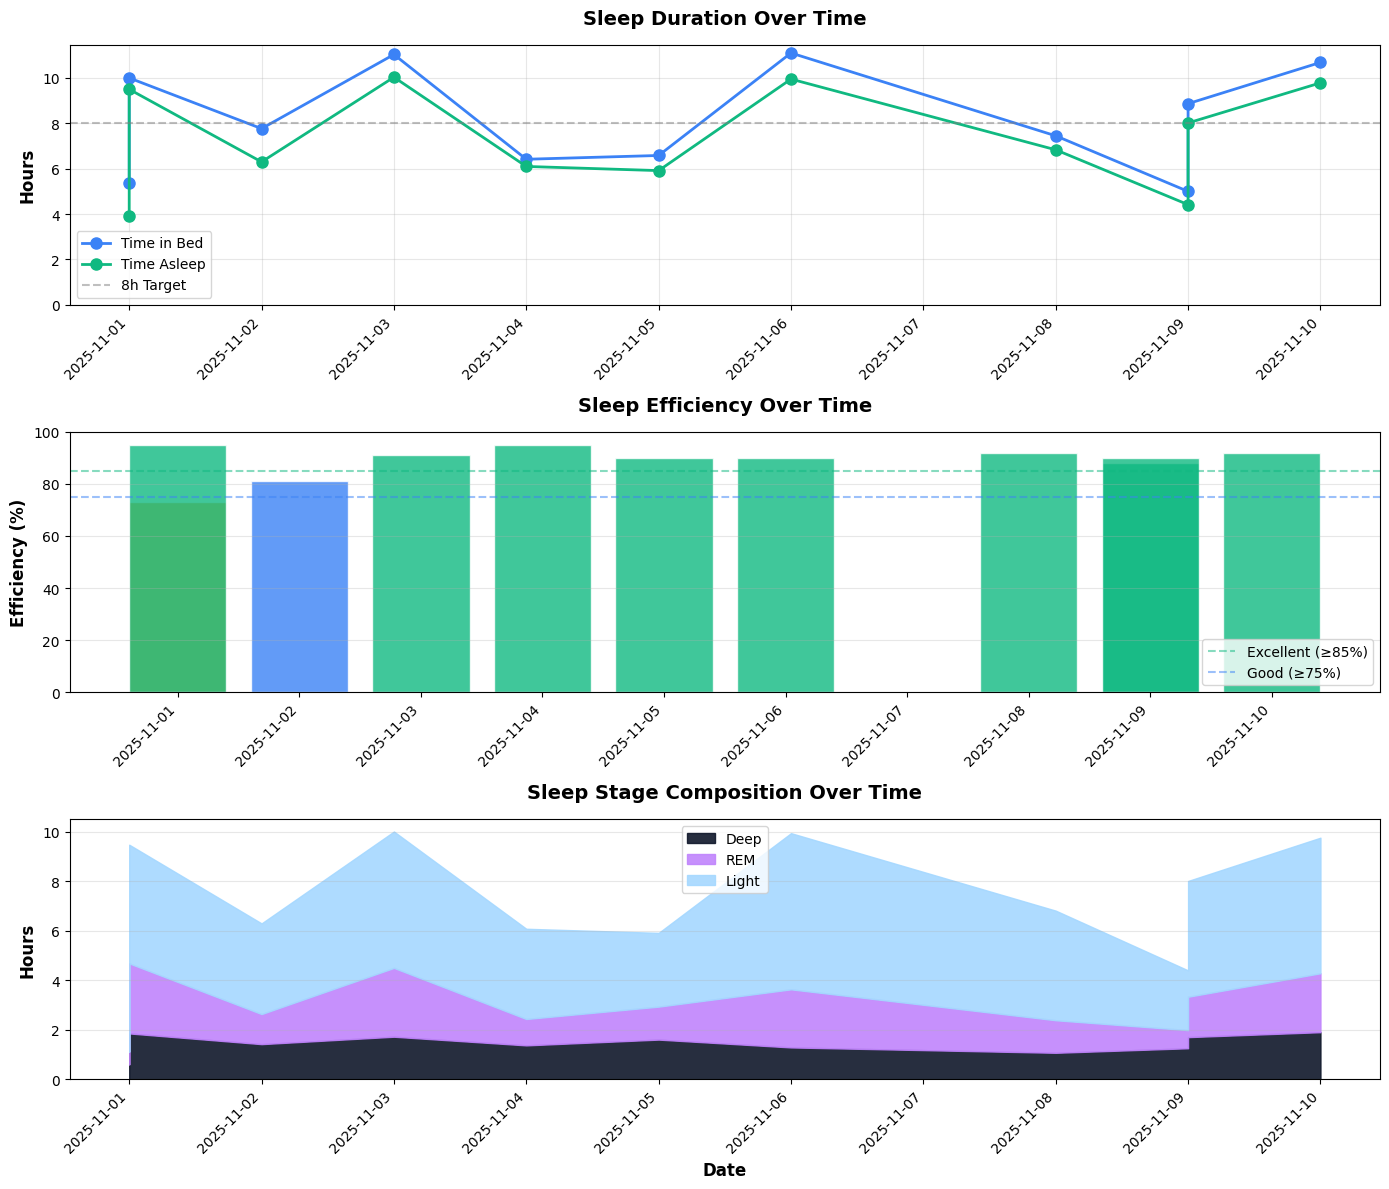

In [183]:
# Multi-day trend analysis
if not df_sleep_summary.empty and not ANALYSIS_DATE:
    print("📊 Generating multi-day trend analysis...\n")
    fig_trends = plot_sleep_trends(df_sleep_summary)
else:
    if ANALYSIS_DATE:
        print("⏭️  Skipping multi-day analysis (ANALYSIS_DATE is set)")
    else:
        print("❌ Cannot plot trends - no sleep data available")

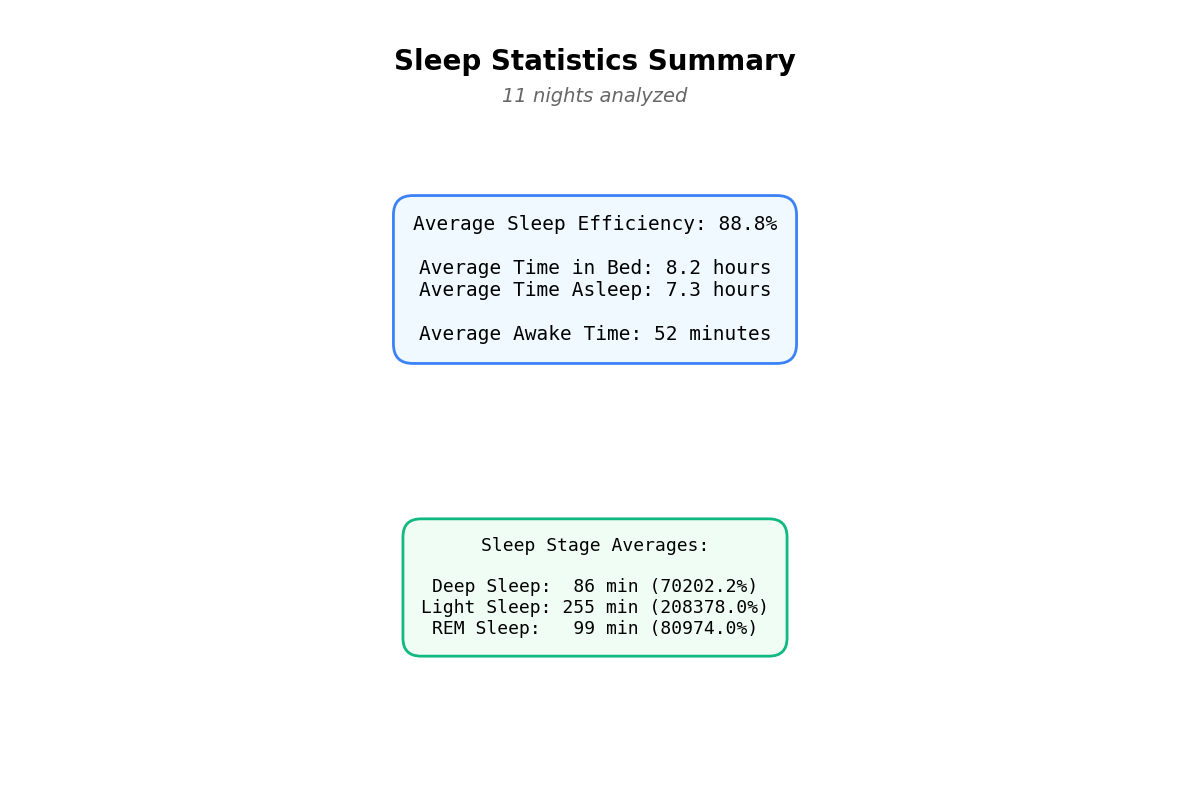

In [184]:
# Summary statistics for date range
if not df_sleep_summary.empty and not ANALYSIS_DATE:
    fig_stats = plot_sleep_summary_stats(df_sleep_summary)
else:
    if ANALYSIS_DATE:
        print("⏭️  Skipping summary stats (ANALYSIS_DATE is set)")
    else:
        print("❌ Cannot plot summary stats - no sleep data available")

In [185]:
### Single-Day Detailed Analysis

Only runs if ANALYSIS_DATE is set to a specific date.

SyntaxError: expected 'else' after 'if' expression (590509929.py, line 3)

In [ ]:
# Single-day analysis: Extract data for specific date
if ANALYSIS_DATE:
    dfs = get_sleep_data_for_date(df_all, ANALYSIS_DATE)
    
    if dfs:
        df_sleep_levels_single = dfs.get('SleepLevels')
        df_sleep_summary_single = dfs.get('SleepSummary')
        
        # Process times
        if df_sleep_levels_single is not None:
            df_sleep_levels_single['end_time'] = df_sleep_levels_single['time'] + pd.to_timedelta(df_sleep_levels_single['duration_seconds'], unit='s')
        
        if df_sleep_summary_single is not None:
            if 'endTime' in df_sleep_summary_single.columns:
                df_sleep_summary_single['end_time'] = pd.to_datetime(df_sleep_summary_single['endTime'])
            elif 'end_time' not in df_sleep_summary_single.columns:
                df_sleep_summary_single['end_time'] = df_sleep_summary_single['time'] + pd.to_timedelta(df_sleep_summary_single['minutesInBed'], unit='m')
            
            df_sleep_summary_single['duration_hours'] = (df_sleep_summary_single['end_time'] - df_sleep_summary_single['time']).dt.total_seconds() / 3600
        
        # Convert timezones
        if df_sleep_summary_single is not None:
            df_sleep_summary_single['time'] = df_sleep_summary_single['time'].dt.tz_convert(TIMEZONE)
            df_sleep_summary_single['end_time'] = df_sleep_summary_single['end_time'].dt.tz_convert(TIMEZONE)
        
        if df_sleep_levels_single is not None:
            df_sleep_levels_single['time'] = df_sleep_levels_single['time'].dt.tz_convert(TIMEZONE)
            df_sleep_levels_single['end_time'] = df_sleep_levels_single['end_time'].dt.tz_convert(TIMEZONE)
            
            # Decode levels
            level_decode = {0: 'Deep', 1: 'Light', 2: 'REM', 3: 'Awake'}
            df_sleep_levels_single['level_name'] = df_sleep_levels_single['level'].map(level_decode)
        
        print("✅ Single-day data prepared")
    else:
        print(f"❌ No data found for {ANALYSIS_DATE}")
else:
    print("⏭️  Skipping single-day analysis (ANALYSIS_DATE not set)")

In [ ]:
# Print sleep summary for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_summary_single is not None:
    for idx, row in df_sleep_summary_single.iterrows():
        is_main = row.get('isMainSleep', 'Unknown')
        session_type = "🌙 MAIN SLEEP" if is_main == 'True' else "💤 NAP"
        
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        
        # Calculate sleep date
        sleep_hour = start.hour
        if sleep_hour >= 18:
            sleep_date = start.date()
        elif sleep_hour < 6:
            sleep_date = (start - pd.Timedelta(days=1)).date()
        else:
            sleep_date = start.date()
        
        asleep_hr = row['minutesAsleep'] / 60
        awake_min = row.get('minutesAwake', 0)
        efficiency = row.get('efficiency', 0)
        minutes_in_bed = int(row['minutesInBed'])
        hours_in_bed = minutes_in_bed // 60
        mins_in_bed = minutes_in_bed % 60
        
        deep = row.get('minutesDeep', 0)
        light = row.get('minutesLight', 0)
        rem = row.get('minutesREM', 0)

        print(f"\n{session_type}")
        print("-" * 60)
        print(
            f"📅 Sleep Date:  {sleep_date.strftime('%A, %dth %B %Y')}\n"
            f"🕒 To Bed:      {start.strftime('%H:%M on %A %dth %B')}\n"
            f"🕓 Up & Atom:   {end.strftime('%H:%M on %A %dth %B')}\n"
            f"⏱️ Duration:    {hours_in_bed}h {mins_in_bed}m ({minutes_in_bed} min)\n"
            f"😴 Asleep:      {asleep_hr:.2f} hrs ({row['minutesAsleep']:.0f} min)\n"
            f"👁️ Awake:       {awake_min:.0f} min\n"
            f"⚡ Efficiency:  {efficiency:.0f}%\n"
            f"\n💤 Sleep Stages:\n"
            f"   Deep:  {deep:.0f} min ({deep/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   Light: {light:.0f} min ({light/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   REM:   {rem:.0f} min ({rem/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)"
        )
        print("\n" + "=" * 60)

In [ ]:
# Sleep timeline for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_levels_single is not None and df_sleep_summary_single is not None:
    fig1 = plot_sleep_timeline(df_sleep_levels_single, df_sleep_summary_single)
else:
    if not ANALYSIS_DATE:
        print("⏭️  Skipping timeline (ANALYSIS_DATE not set)")

In [ ]:
# Sleep stages pie chart for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_levels_single is not None and df_sleep_summary_single is not None:
    fig2 = plot_sleep_stages_pie(df_sleep_levels_single, df_sleep_summary_single)
else:
    if not ANALYSIS_DATE:
        print("⏭️  Skipping pie chart (ANALYSIS_DATE not set)")

In [ ]:
# Sleep efficiency for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_summary_single is not None:
    fig3 = display_sleep_efficiency(df_sleep_summary_single)
else:
    if not ANALYSIS_DATE:
        print("⏭️  Skipping efficiency display (ANALYSIS_DATE not set)")

In [ ]:
# Naps timeline for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_levels_single is not None and df_sleep_summary_single is not None:
    fig4 = plot_naps_timeline(df_sleep_levels_single, df_sleep_summary_single)
else:
    if not ANALYSIS_DATE:
        print("⏭️  Skipping naps analysis (ANALYSIS_DATE not set)")

In [ ]:
# Sleep stages bar for single day
if ANALYSIS_DATE and dfs is not None and df_sleep_levels_single is not None and df_sleep_summary_single is not None:
    fig5 = plot_sleep_stages_bar(df_sleep_levels_single, df_sleep_summary_single)
else:
    if not ANALYSIS_DATE:
        print("⏭️  Skipping sleep stages bar (ANALYSIS_DATE not set)")